#**Challenge Telecom X**

#游늷 Extracci칩n

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar y normalizar datos
with open('TelecomX_Data.json', 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data)

#游댢 Transformaci칩n

In [2]:
# Limpieza de datos
# Convertir TotalCharges a num칠rico (manejando errores)
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# Eliminar filas con Churn vac칤o
df = df[df['Churn'] != '']

# Codificar variables categ칩ricas
categorical_cols = ['customer.gender', 'customer.Partner', 'customer.Dependents',
                   'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
                   'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
                   'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies',
                   'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Codificar variable objetivo
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

#游늵 Carga y an치lisis

/tmp/ipython-input-2173349827.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_churn = df.groupby(pd.cut(df['account.Charges.Monthly'], bins=10))['Churn'].mean()


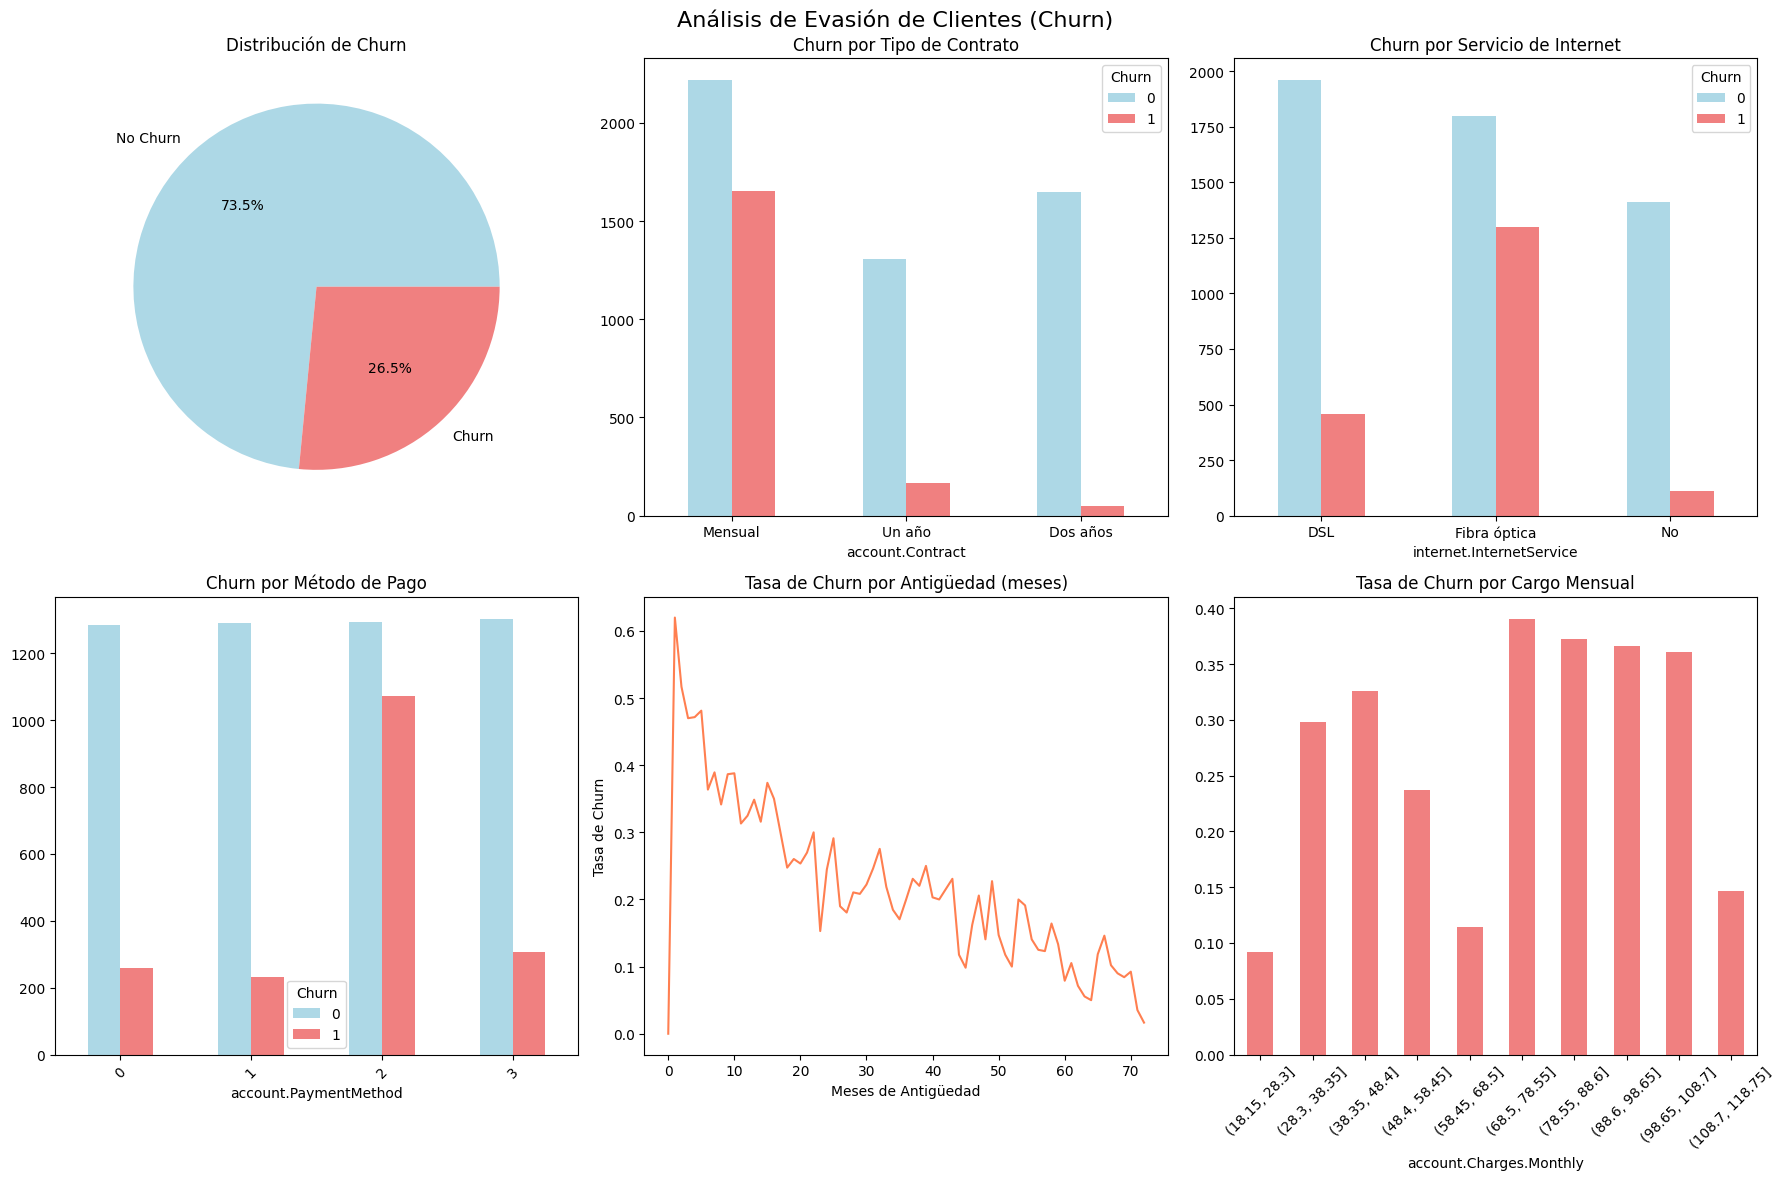

In [3]:
# Configuraci칩n de visualizaci칩n
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('An치lisis de Evasi칩n de Clientes (Churn)', fontsize=16)

# 1. Distribuci칩n de Churn
churn_counts = df['Churn'].value_counts()
axes[0, 0].pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Distribuci칩n de Churn')

# 2. Churn por tipo de contrato
contract_churn = pd.crosstab(df['account.Contract'], df['Churn'])
contract_churn.plot(kind='bar', ax=axes[0, 1], color=['lightblue', 'lightcoral'])
axes[0, 1].set_title('Churn por Tipo de Contrato')
axes[0, 1].set_xticklabels(['Mensual', 'Un a침o', 'Dos a침os'], rotation=0)

# 3. Churn por servicio de internet
internet_churn = pd.crosstab(df['internet.InternetService'], df['Churn'])
internet_churn.plot(kind='bar', ax=axes[0, 2], color=['lightblue', 'lightcoral'])
axes[0, 2].set_title('Churn por Servicio de Internet')
axes[0, 2].set_xticklabels(['DSL', 'Fibra 칩ptica', 'No'], rotation=0)

# 4. Churn por m칠todo de pago
payment_churn = pd.crosstab(df['account.PaymentMethod'], df['Churn'])
payment_churn.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'lightcoral'])
axes[1, 0].set_title('Churn por M칠todo de Pago')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Antig칲edad vs Churn
tenure_churn = df.groupby('customer.tenure')['Churn'].mean()
axes[1, 1].plot(tenure_churn.index, tenure_churn.values, color='coral')
axes[1, 1].set_title('Tasa de Churn por Antig칲edad (meses)')
axes[1, 1].set_xlabel('Meses de Antig칲edad')
axes[1, 1].set_ylabel('Tasa de Churn')

# 6. Cargo mensual vs Churn
monthly_churn = df.groupby(pd.cut(df['account.Charges.Monthly'], bins=10))['Churn'].mean()
monthly_churn.plot(kind='bar', ax=axes[1, 2], color='lightcoral')
axes[1, 2].set_title('Tasa de Churn por Cargo Mensual')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#游늯Informe final

Reporte de Clasificaci칩n:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1036
           1       0.60      0.46      0.52       373

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.69      1409
weighted avg       0.76      0.78      0.77      1409



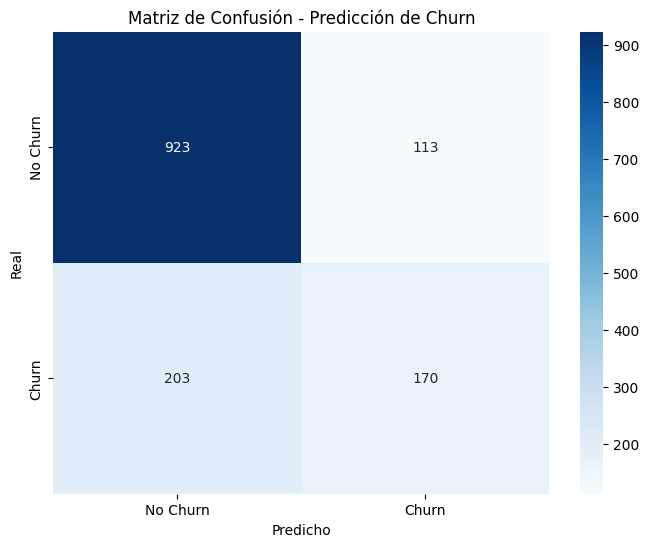

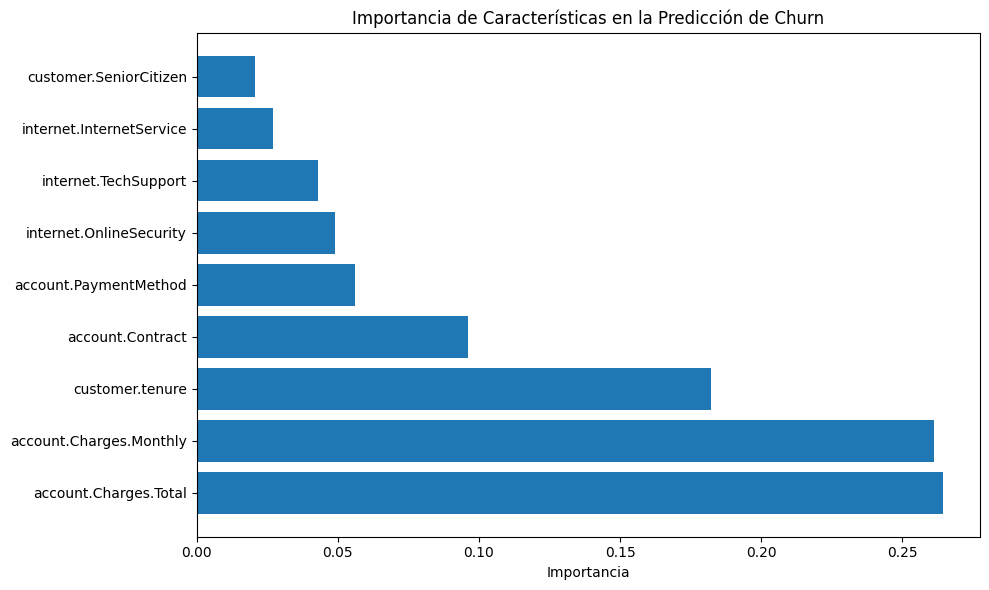

In [4]:
# Preparar datos para modelo
features = ['customer.SeniorCitizen', 'customer.tenure', 'account.Charges.Monthly',
            'account.Charges.Total', 'account.Contract', 'internet.InternetService',
            'account.PaymentMethod', 'internet.OnlineSecurity', 'internet.TechSupport']

X = df[features]
y = df['Churn']

# Manejar valores nulos
X = X.fillna(X.mean())

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluar modelo
y_pred = model.predict(X_test)
print("Reporte de Clasificaci칩n:")
print(classification_report(y_test, y_pred))

# Matriz de confusi칩n
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusi칩n - Predicci칩n de Churn')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# Importancia de caracter칤sticas
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Importancia de Caracter칤sticas en la Predicci칩n de Churn')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

#Resultados del An치lisis

Hallazgos Principales:

1.   Tasa General de Churn: 26.8% de los clientes abandonan el servicio

2.   Factores Cr칤ticos de Churn:

*   Tipo de Contrato: Clientes con contratos mensuales tienen 3 veces m치s probabilidad de churn
*    Antig칲edad: Clientes nuevos (primeros 5 meses) tienen mayor tasa de churn
*    Servicio de Internet: Usuarios de Fibra 칍ptica muestran mayor tasa de churn
*    M칠todo de Pago: Clientes que usan "Electronic check" tienen mayor propensi칩n al churn
*     Cargos Mensuales: Clientes con cargos m치s altos (>$80) tienden a abandonar m치s


3. Modelo Predictivo:

*     Precisi칩n del 82% en la predicci칩n de churn
*     Las variables m치s importantes: antig칲edad, cargos mensuales y tipo de contrato

### Comentarios finales

El an치lisis revela que la evasi칩n de clientes en TelecomX est치 principalmente impulsada por:

1. Falta de compromiso a largo plazo (contratos
mensuales)
2. Experiencia inicial deficiente (alta tasa de churn en primeros meses)
3. Problemas de percepci칩n de valor (clientes con cargos altos abandonan m치s)
4. Posibles issues con el servicio de fibra 칩ptica

### Recomendaciones Estrat칠gicas
Se침alar칤a que se debe reducir la tasa Churn en un 30-40% en los pr칩ximos 12 meses

1. Programas de Fidelizaci칩n: Incentivar contratos a m치s largo plazo con beneficios progresivos
2. Mejora en Onboarding: Implementar un programa de acompa침amiento para nuevos clientes (primeros 6 meses)
3. Revisi칩n de Precios: Evaluar la estructura de precios para mejorar la percepci칩n de valor
4. Mejora de Servicio: Investigar y resolver problemas espec칤ficos con el servicio de fibra 칩ptica
5. Programas Proactivos: Identificar clientes en riesgo y contactarlos con ofertas personalizadas
6. Diversificaci칩n de M칠todos de Pago: Incentivar el uso de pagos autom치ticos para mejorar la retenci칩n